# Exercise 4 - Spelling Correction with Naive Bayes (30 Points)

In this exercise you will learn about a fun application of the *Naive Bayes* classifier: Spelling correction. For the
informal and vivid character of natural language, the correction of syntactic and semantic errors in written language is an extremely hard task. Here you will challenge this problem by applying one of the simplest classification
algorithms, namely Naive Bayes and see how it performs.

In the event of a persistent problem, do not hesitate to contact the course instructors under
- christoph.staudt@uni-jena.de

### Submission

- Deadline of submission:
        19.05.2021 23:59
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=28746)

## Intro

This exercise is based on section 5.1 in *Speech and Language Processing* by Daniel Jurafsky & James H. We will implement the model and required functions stept by step, but if you are intereseted in reading about it in one go with more explanations you can do so in the file `chapter5.pdf`.


## Problem statement
We frame spelling correction as a classification problem and use Bayesian inference to obtain results. Although the
basic problem statement is straightforward, there is plenty of room to improve the used models, initially
published by Peter Norvig.

Given an observation $x$ and a corpus of words $W$. For spelling correction, we want to find the most likely correction $w\in W$ for $x$.
In other words, we are looking for 

\begin{align*}
\text{argmax}_{w\in W}p(w|x)&=\text{argmax}_{w\in W}\cfrac{p(x|w)p(w)}{p(x)}\\
&=\text{argmax}_{w\in W}p(x|w)p(w)
\end{align*}

In practice, we do not want to maximize over the complete corpus of words, but rather only over a set of candidate words $C_x\subset W$ that depends on the observed pattern $x$.

\begin{align*}
\text{argmax}_{w\in C_x}p(x|w)p(w)
\end{align*}

## Language Model
The probability $p(w)$ is also called **language model**, since it represents our model of how words are distributed.
There are multiple classes of language models. 
The simplest class of model is the unigram model, where the probability of each word is fixed and can be obtained by using the frequency of its occurrence in a given corpus.
Within the directory `books` you will find several `.txt` files that contain (parts) of books from the [Project Gutenberg](https://www.gutenberg.org). This source shall provide the basis for obtaining the corpus $W$ and for training a language model.


### Task 1 (2 Points)
Load the book texts from the `.txt` files, filter the alphabetic
expressions and calculate the frequencies of occurrences of the existing words.
What are the top 10 most occuring words, how often to they occur? 

Make sure to store $W$ in a data structure, where you can quickly check if $w\in W$ for a word $w$ (see [here](https://wiki.python.org/moin/TimeComplexity)).

Hints:
- the files are encoded in utf-8
- use [regex](https://docs.python.org/3/library/re.html) to filter for words
- lower case the words
- You may want to use one of the more [specialized datatypes](https://realpython.com/python-collections-module/)


In [92]:
import re
import glob
from collections import Counter

# TODO: load books
books = []
for book_path in glob.glob("books/*.txt"):
    with open(book_path, 'r', encoding='utf8') as f:
        books.append(f.read())

# TODO: count words
corpus = Counter()
for book in books:
    words = re.findall(r'\b\w+\b', book)
    corpus += Counter([word.lower() for word in words])

top10_words = corpus.most_common(10)
# Counter.total() somehow didn't work, so i'm caching it here
total_words = sum(corpus.values())

assert top10_words == [('the', 55160),
 ('and', 32870),
 ('of', 28632),
 ('to', 27333),
 ('i', 21438),
 ('a', 21437),
 ('in', 17390),
 ('that', 14731),
 ('it', 13854),
 ('he', 12482)]

### Task 2 (1 Point)
Use the loaded corpus to implement a function that resembles our language model.
Use relative frequencies as estimates for $p(w)$.

In [93]:
def language_model(w):
    # TODO: implement language model
    return corpus[w] / total_words

assert language_model('the') == 0.052811928832191914

## Candidate Words
Real-world-spelling-errors take multiple shapes. There are typographical errors like insertions, deletions and trans-
positions of letters, and there are cognitive errors where the writer substitutes a wrong spelling of a homophone or
near-homophone (e.g., dessert for desert, or piece for peace). The detection of the latter require context information
and therefore are hard to detect. Thus we focus on the former, which are errors that were produced by the following
operations:
- transposition (e.g. "catress" for "actress" : "ac" $\rightarrow$ "ca")
- deletion ("acress" for "actress": missing "t")
- substitutions ("acress" for "access": substituted "r" for "c")
- insertions ("actresss" for "actress": added "s")

Given an observation $x$, we create a set of possible candidates $C_x$ by applying all the possible edit operators on $x$. By concatenating operations, you can transform each word into any other arbitrary word. Yet, to keep things simply
we only consider candidates witch are *at most one* edit distance away from $x$. 

For instance, the correction candidates for the word "nie", could be:

\begin{equation*}
C_{\text{nie}} = \{\text{die}, \text{lie}, \text{pie}, \text{tie}, \text{nice}, \text{nine}, \text{in}\}
\end{equation*}

### Task 3 (5 Points)
Implement a function that creates a set of all possible correction candidates for a given observation $x$,
that are at most one edit distance away from $x$. You should not concatenate operations! The function should only return a candidate $c$ if it occurs in the corpus, i.e. $ c \in W$.


In [94]:
import string

def swap(s, i, j):
    lst = list(s)
    lst[i], lst[j] = lst[j], lst[i]
    return ''.join(lst)

def transposes(x):
    # TODO: possible transpositions
    return [swap(x, i, i + 1) for i in range(len(x) - 1)]

def deletes(x):
    # TODO: possible deletes
    return [x[:i] + x[i + 1:] for i in range(len(x))]

def substitutions(x):
    # TODO: possible substitutions
    return [x[:i] + c + x[i + 1:] for i in range(len(x)) for c in string.ascii_lowercase]
    
def insertions(x):
    # TODO: possible insertions
    return [x[:i] + c + x[i:] for i in range(len(x) + 1) for c in string.ascii_lowercase]

def candidates(x): 
    # TODO: possible candidates
    return [word for word in [x] + transposes(x) + deletes(x) + substitutions(x) + insertions(x) if word in corpus]

assert transposes('frod') == ['rfod', 'ford', 'frdo']
assert deletes('frod') == ['rod', 'fod', 'frd', 'fro']
assert substitutions('frod') == ['arod', 'brod', 'crod', 'drod', 'erod', 'frod', 'grod', 'hrod', 'irod', 'jrod', 'krod', 'lrod', 'mrod', 'nrod', 'orod', 'prod', 'qrod', 'rrod', 'srod', 'trod', 'urod', 'vrod', 'wrod', 'xrod', 'yrod', 'zrod', 'faod', 'fbod', 'fcod', 'fdod', 'feod', 'ffod', 'fgod', 'fhod', 'fiod', 'fjod', 'fkod', 'flod', 'fmod', 'fnod', 'food', 'fpod', 'fqod', 'frod', 'fsod', 'ftod', 'fuod', 'fvod', 'fwod', 'fxod', 'fyod', 'fzod', 'frad', 'frbd', 'frcd', 'frdd', 'fred', 'frfd', 'frgd', 'frhd', 'frid', 'frjd', 'frkd', 'frld', 'frmd', 'frnd', 'frod', 'frpd', 'frqd', 'frrd', 'frsd', 'frtd', 'frud', 'frvd', 'frwd', 'frxd', 'fryd', 'frzd', 'froa', 'frob', 'froc', 'frod', 'froe', 'frof', 'frog', 'froh', 'froi', 'froj', 'frok', 'frol', 'from', 'fron', 'froo', 'frop', 'froq', 'fror', 'fros', 'frot', 'frou', 'frov', 'frow', 'frox', 'froy', 'froz']
assert insertions('frod') == ['afrod', 'bfrod', 'cfrod', 'dfrod', 'efrod', 'ffrod', 'gfrod', 'hfrod', 'ifrod', 'jfrod', 'kfrod', 'lfrod', 'mfrod', 'nfrod', 'ofrod', 'pfrod', 'qfrod', 'rfrod', 'sfrod', 'tfrod', 'ufrod', 'vfrod', 'wfrod', 'xfrod', 'yfrod', 'zfrod', 'farod', 'fbrod', 'fcrod', 'fdrod', 'ferod', 'ffrod', 'fgrod', 'fhrod', 'firod', 'fjrod', 'fkrod', 'flrod', 'fmrod', 'fnrod', 'forod', 'fprod', 'fqrod', 'frrod', 'fsrod', 'ftrod', 'furod', 'fvrod', 'fwrod', 'fxrod', 'fyrod', 'fzrod', 'fraod', 'frbod', 'frcod', 'frdod', 'freod', 'frfod', 'frgod', 'frhod', 'friod', 'frjod', 'frkod', 'frlod', 'frmod', 'frnod', 'frood', 'frpod', 'frqod', 'frrod', 'frsod', 'frtod', 'fruod', 'frvod', 'frwod', 'frxod', 'fryod', 'frzod', 'froad', 'frobd', 'frocd', 'frodd', 'froed', 'frofd', 'frogd', 'frohd', 'froid', 'frojd', 'frokd', 'frold', 'fromd', 'frond', 'frood', 'fropd', 'froqd', 'frord', 'frosd', 'frotd', 'froud', 'frovd', 'frowd', 'froxd', 'froyd', 'frozd', 'froda', 'frodb', 'frodc', 'frodd', 'frode', 'frodf', 'frodg', 'frodh', 'frodi', 'frodj', 'frodk', 'frodl', 'frodm', 'frodn', 'frodo', 'frodp', 'frodq', 'frodr', 'frods', 'frodt', 'frodu', 'frodv', 'frodw', 'frodx', 'frody', 'frodz']
# order was wrong, shouldn't matter tho
assert set(candidates("frod")) == set(['food', 'frog', 'trod', 'fro', 'ford', 'from', 'rod'])
assert set(candidates("that")) == set(['chat', 'that', 'tat', 'hat', 'than', 'what'])

## Error Model
Recall the problem statement:
The probability $p(x|w)$ for $w\in C\subset W$ is also called **error model**, since it represents how likely $w$ was mispelled as the observed pattern $x$.

A very simple error model can be achieved by setting

\begin{equation*}
p(x|w) := p(w),
\end{equation*}

which reduces our initial problem to: 

\begin{align*}
\text{argmax}_{w\in C}p(w)p(w) = \text{argmax}_{w\in C}p(w).
\end{align*}

### Task 4 (2 Points)
Implement a function `correction`, that returns $\text{argmax}_{w\in W}p(w|x)$ for a given input $x$, based on the above definition.

Also think about what `correction` should return
- if $x$ is a known word?
- if $x$ is unknown and has no correction candidates?

<details><summary>Answers</summary>
In both cases x should be returned.
</details>

What is the correction for the word "frod"?

In [95]:
import numpy as np

def correction(x): 
    # TODO: return correction candidate
    # if it's already a word, don't correct it
    if x in corpus:
        return x
    C = candidates(x)
    # if we don't have any idea, don't correct it
    if len(C) == 0:
        return x
    probs = [language_model(w) for w in C]
    return C[np.argmax(probs)]
    

assert correction('sucess') == 'success'
correction('frod')

'from'

### Task 5 (2 Points)
The file `dataset.p` contains a list of spelling data from several [corpora of misspellings](https://www.dcs.bbk.ac.uk/~ROGER/corpora.html), where each item contains a tuple of the form:

\begin{equation}
\text{misspelled word, correct word}
\end{equation}

The dataset has been preprocessed, so each misspelling is one edit distance away from the correct word.
Load the dataset and split it into a training (80%) and test set (20%). Since you just need to do a single split you can use [np.random.shuffle(dataset)](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html).

The file was created using [pickle](https://wiki.python.org/moin/UsingPickle).

In [96]:
import pickle

# TODO: Load dataset
dataset = np.array(pickle.load(open("dataset.p", 'rb')))

# Make sure dataset is a numpy array
assert isinstance(dataset, np.ndarray)

# TODO: Split into train- and testset
np.random.seed(0)
np.random.shuffle(dataset)
cut_index = int(len(dataset) * 0.8)
trainset = dataset[:cut_index]
testset = dataset[cut_index:]

# If you use shuffle this should work out, if not
# you can write me or ignore them, but all the assertions below
# will be wrong as well then
assert trainset[4, 0] == 'priveliged'
assert trainset[37, 0] == 'san'
assert testset[4, 0] == 'wishas'
assert testset[37, 0] == 'yow'

### Task 6 (3 Points)

Implement a function `validate`, that takes a correction function (takes a word, outputs a suggestion) tries to correct the typos in the testset. Use only the data, where the correct word is actually in our word corpus $W$.

`validate` should return a list of the cases, where the correction failed, as well as the success rate (percentage of correctly corrected typos).

What is your success rate? On which words did your spelling correction fail and why?

In [97]:
def validate(correction_function):
    # TODO: estimate success rate
    validation_set = np.array([[typo, correct] for typo, correct in testset if correct in corpus])
    success = np.array([correction_function(typo) == correct for typo, correct in validation_set])
    success_rate = np.count_nonzero(success) / len(validation_set)
    return validation_set[success == False], success_rate

# TODO: estimate success rate, view failed corrections
failed, success_rate = validate(correction)

# NOTE: changed from 0.7011669203450026 to 0.7011669203450025 (last digit 6 -> 5), close enough
assert success_rate == 0.7011669203450025
# TODO: Print some failed words Observed: x, seelcted candidate: w, correct word: 
for typo, correct in failed[:10]:
    print(f"typo: {typo}\tcorrect: {correct},\tcorrection:{correction(typo)}")

typo: ommitting	correct: omitting,	correction:committing
typo: put	correct: but,	correction:put
typo: remove	correct: removed,	correction:remove
typo: hungary	correct: hungry,	correction:hungary
typo: hide	correct: hid,	correction:hide
typo: rick	correct: rich,	correction:dick
typo: couse	correct: cause,	correction:house
typo: move	correct: moved,	correction:move
typo: thing	correct: think,	correction:thing
typo: looses	correct: loses,	correction:loose


As you can see if the wrong word is in our dictionary that will automatically lead to an error since we just return it again. Fixing these kind of errors requires to go beyond the unigramm model and take the surrrounding context of the word into consideration. We won't do this here so next overwrite the validate function and skip cases where the wrong word is in the dictionary. (Still Task 6)

In [98]:
def validate(correction_function):
    # TODO: estimate success rate and exclude wrong words that are in our dictionary
    validation_set = np.array([[typo, correct] for typo, correct in testset if correct in corpus and not typo in corpus])
    success = np.array([correction_function(typo) == correct for typo, correct in validation_set])
    success_rate = np.count_nonzero(success) / len(validation_set)
    return validation_set[success == False], success_rate

# TODO: estimate success rate, view failed corrections
failed, success_rate = validate(correction)

assert success_rate ==  0.7988439306358381
# TODO: Print some failed words Observed: x, seelcted candidate: w, correct word:
for typo, correct in failed[:10]:
    print(f"typo: {typo}\tcorrect: {correct},\tcorrection:{correction(typo)}")

typo: ommitting	correct: omitting,	correction:committing
typo: rick	correct: rich,	correction:dick
typo: couse	correct: cause,	correction:house
typo: looses	correct: loses,	correction:loose
typo: tham	correct: them,	correction:that
typo: folloy	correct: folly,	correction:follow
typo: leat	correct: left,	correction:let
typo: borde	correct: bored,	correction:bore
typo: bast	correct: best,	correction:last
typo: oll	correct: oil,	correction:all


### Transformations and confusion

By analyzing the output of your spelling corrector, you find examples where the corrected word is indeed a real
word, but not the expected one, for example:

\begin{equation*}
x=\text{"tham"}, w=\text{"them"}, \text{correction}=\text{"that"}
\end{equation*}

This phenomena occurs due to the simplistic nature of our error model. Currently "that" is suggested as correction, because the word "that" is more likely than the word "them", but this does not account for the fact that substituting an "a" with an "e" is more likely than substituting an "m" with a "t".

Instead of treating each error equally, we now consider the probability of the edit required to get from $w$ to $x$. We will need four confusion matrices:
- $\operatorname{del}[a,b]$: count($ab$ typed as $a$), i.e. $w$ contains the character sequence $ab$, but $b$ was deleted in $x$.
- $\operatorname{ins}[a,b]$: count($a$ typed as $ab$), i.e. $w$ contains the character $a$ and $b$ was inserted after $a$ in $x$.
- $\operatorname{sub}[a,b]$: count($a$ typed as $b$), i.e. $w$ contains the character $a$, but in $x$ there is a $b$ instead of an $a$.
- $\operatorname{trans}[a,b]$: count($ab$ typed as $ba$), i.e. $w$ contains the character sequence $ab$, but in $x$ it was swapped to $ba$.


In order to construct these matrices, we need a way to find out, which transformation took place.

### Task 7 (5 Points)

Implement the function `get_transformation`, which takes the correct word and the misspelled word as input. The function should output three things:
- ID of transformation (del, ins, sub or trans)
- a of transformation 
- b of transformation

where a and b are defined for each transformation as mentioned above. You may also look at the asssertions below to get an understanding of their definitions. Insertions or deletions at the start of the word will need an a that is not in the word. We will use the character "#" for this. Remember, that every misspelling  is generated by only one transformation .

<details>
<summary>Open to get implementation hints</summary>
 Compare the characters of the words one by one to find the first place where they defer. Then use the length of the words and the next character to determine which transformation happened
</details>

In [99]:
def get_transformation(wrong, right):
    # TODO: returns id, x, y of transformation
    max_length = max(len(wrong), len(right))
    # pad empty chars so we don't have to worry about edge cases
    wrong = f"#{wrong}#-"
    right = f"#{right}#-"
    # indices must be adapted for padding
    for i in range(1, max_length + 1):
        if wrong[i] == right[i]:
            continue
        # wrong[i] != right[i]
        # abc <- ac
        if len(wrong) > len(right):
            return 'ins', wrong[i - 1], wrong[i]
        # ac <- abc
        if len(wrong) < len(right):
            return 'del', right[i - 1], right[i]
        # bc <- ac
        if wrong[i + 1] == right[i + 1]:
            return 'sub', right[i], wrong[i]
        # bac <- abc
        if wrong[i] == right[i + 1] and wrong[i + 1] == right[i]:
            return 'trans', right[i], right[i + 1]
            
            

assert get_transformation('frod','from') == ('sub', 'm', 'd')
assert get_transformation('fromm', 'from') == ('ins', 'm', 'm')
assert get_transformation('frm', 'from') == ('del', 'r', 'o')
assert get_transformation('frmo', 'from') == ('trans', 'o', 'm')
assert get_transformation('rom', 'from') == ('del', '#', 'f')
assert get_transformation('afrom', 'from') == ('ins', '#', 'a')

### Task 8 (2 Points)

Use the `get_transformation` function and the trainset to create the confusion matrices.

In [100]:
import string
alphabet = string.ascii_lowercase
del_matrix = np.zeros((len(alphabet)+1, len(alphabet)))
ins_matrix = np.zeros((len(alphabet)+1, len(alphabet)))
sub_matrix = np.zeros((len(alphabet), len(alphabet)))
trans_matrix = np.zeros((len(alphabet), len(alphabet)))

# easier access to matrix indices, '#' is added as the last letter
char_index = {c: i for i, c in enumerate(alphabet)}
char_index['#'] = len(alphabet)

# TODO: Fill confusion matrices
for typo, correct in trainset:
    id, a, b = get_transformation(typo, correct)
    if id == 'del':
        del_matrix[char_index[a], char_index[b]] -=- 1
    elif id == 'ins':
        ins_matrix[char_index[a], char_index[b]] -=- 1
    elif id == 'sub':
        sub_matrix[char_index[a], char_index[b]] -=- 1
    elif id == 'trans':
        trans_matrix[char_index[a], char_index[b]] -=- 1

# As claimed above substitution of a and e much more likely
assert sub_matrix[alphabet.find('a'),alphabet.find('e')] ==  204.0
assert sub_matrix[alphabet.find('e'),alphabet.find('a')] ==  261.0
assert sub_matrix[alphabet.find('m'),alphabet.find('t')] ==  0.0
assert sub_matrix[alphabet.find('t'),alphabet.find('m')] ==  0.0

# NOTE: it gets tricky here: the transformation id is unique, but (a, b) isn't.
# e.g. aas <- as could be:
# 'ins', 'a', 'a' or 'ins', '#', 'a'
# so i'll just ignore these 2

# assert del_matrix[0,0] == 4
# assert ins_matrix[1,3] == 1
assert trans_matrix[5,4] == 2

### Task 9 (1 Point)
Visualize the confusion matrices. Are the results as you would expect?

Hint: Review Solution of Exercise 1 Task 5 (Correlation matrix)

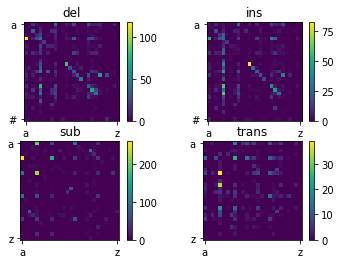

In [101]:
import matplotlib.pyplot as plt

# TODO: visualize confusion matrices
plt.subplot(221)
plt.title('del')
plt.imshow(del_matrix)
plt.xticks([0, 25], ['a', 'z'])
plt.yticks([0, 26], ['a', '#'])
plt.colorbar()
plt.subplot(222)
plt.title('ins')
plt.imshow(ins_matrix)
plt.xticks([0, 25], ['a', 'z'])
plt.yticks([0, 26], ['a', '#'])
plt.colorbar()
plt.subplot(223)
plt.title('sub')
plt.imshow(sub_matrix)
plt.xticks([0, 25], ['a', 'z'])
plt.yticks([0, 25], ['a', 'z'])
plt.colorbar()
plt.subplot(224)
plt.title('trans')
plt.imshow(trans_matrix)
plt.xticks([0, 25], ['a', 'z'])
plt.yticks([0, 25], ['a', 'z'])
plt.colorbar()
plt.show()

### From confusion to probability

The confusion matrices alone are not sufficient to estimate the error probability. In order do that we need a base count of how often that transformation could have happened. As this depends on the type of transformation, we will define the error probability $p(x|w)$ for each of them individually now. Instead of considering the whole words $x$ and $w$, we will simply look at the error on the character level $a$ and $b$.


**Deletion**

The candidate word $w$ contains the character sequence $ab$, but $b$ was deleted in $x$. To estimate how likely deleting $b$ from $ab$ is, we relate it to all occurences of $ab$. Thus, the error probability $$p_{\operatorname{del}}(x|w) = \operatorname{del}[a,b] / \operatorname{count}[ab].$$

As an example consider acress and actress: $$p_{\operatorname{del}}(x="\text{acress}" | w = "\text{actress}") = \operatorname{del}[c,t] /  \operatorname{count}[ct].$$


**Insertion**

The candidate word $w$ contains the character $a$ and $b$ was inserted after $a$ in $x$. This transformation can only happen if an $a$ was in the word, so we relate it to all occurences of $a$ as the base count and 

$$p_{\operatorname{ins}}(x|w) = \operatorname{ins}[a,b] / \operatorname{count}[a].$$

where $\operatorname{count}[\#]$ equals the number of words in the training set. As an example consider sactress and actress: $$p_{\operatorname{ins}}(x="\text{sactress}" | w = "\text{actress}") = \operatorname{ins}[\#,s] /  \operatorname{count}[\#].$$

**Substitution**

The candidate word $w$ contains the character $a$, but in $x$ there is a $b$ instead of an $a$. Again we only need to count all occurences $a$ to get the base count and 

$$p_{\operatorname{sub}}(x|w) = \operatorname{sub}[a,b] / \operatorname{count}[a].$$

As an example consider adtress and actress: $$p_{\operatorname{sub}}(x="\text{adtress}" | w = "\text{actress}") = \operatorname{sub}[c,d] /  \operatorname{count}[c].$$


**Transposition**

The candidate word $w$ contains the character sequence $ab$, but in $x$ it was swapped to $ba$. To estimate how likely swapping $ab$ is, we relate it to all occurences of $ab$. Thus, the error probability $$p_{\operatorname{trans}}(x|w) = \operatorname{trans}[a,b] / \operatorname{count}[ab].$$

As an example consider catress and actress: $$p_{\operatorname{trans}}(x="\text{catress}" | w = "\text{actress}") = \operatorname{trans}[a,c] /  \operatorname{count}[ac].$$




To estimate these probabilities we will need to count the character occurences.

### Task 10 (2 Points)

Count the single and pairwaise character occurences in `trainset`.

In [114]:
char_counts = np.zeros(27)
char_pair_counts = np.zeros((27, 26))

# TODO: Calculate counts
for _, correct_word in trainset:
    prev_char = '#'
    char_counts[char_index['#']] -=- 1
    for char in correct_word:
        char_counts[char_index[char]] -=- 1
        char_pair_counts[char_index[prev_char], char_index[char]] -=- 1
        prev_char = char

# NOTE: my indices are different
assert char_counts[char_index['#']] == 7920
assert char_counts[char_index['b']] == 800
assert char_pair_counts[char_index['#'],char_index['b']] == 401
assert char_pair_counts[char_index['a'],char_index['d']] == 131

### Task 11 (3 Points)

`char_pair_counts` contains several zeros since not all character pairs occur in the training set. To avoid divisions by zero we will use [Laplace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing). This will also avoid zeros in the nominator, so we will use it for all transformations:

$$p_{\operatorname{del}}(x|w) = (\operatorname{del}[a,b] + \alpha) / (\operatorname{count}[ab]+\alpha).$$
$$p_{\operatorname{ins}}(x|w) = (\operatorname{ins}[a,b] + \alpha) / (\operatorname{count}[a] + \alpha)$$
$$p_{\operatorname{sub}}(x|w) = (\operatorname{sub}[a,b] + \alpha) / (\operatorname{count}[a] + \alpha)$$
$$p_{\operatorname{trans}}(x|w) = (\operatorname{trans}[a,b] + \alpha) / (\operatorname{count}[ab] + \alpha)$$
Implement the noisy channel `error_model` function, that calculates $p(x|w)$ by identifying the transformation and calculating the matching smoothed probability as defined above.


In [116]:
def error_model(x,w,alpha):
    # TODO: Calculate p(x|candidate)
    id, a, b = get_transformation(x, w)
    if id == 'del':
        return (del_matrix[char_index[a], char_index[b]] + alpha) / (char_pair_counts[char_index[a], char_index[b]] + alpha)
    if id == 'ins':
        return (ins_matrix[char_index[a], char_index[b]] + alpha) / (char_counts[char_index[a]] + alpha)
    if id == 'sub':
        return (sub_matrix[char_index[a], char_index[b]] + alpha) / (char_counts[char_index[a]] + alpha)
    if id == 'trans':
        return (trans_matrix[char_index[a], char_index[b]] + alpha) / (char_pair_counts[char_index[a], char_index[b]] + alpha)

assert error_model('tham', 'them', 1) == 0.03599395521362825
assert error_model('tham', 'that', 1) == 0.0002486325211337643

### Task 12 (2 Points)
Based on this error model implement the `correction_noisy_channel` function that outputs the best correction candidate:

\begin{align*}
\text{argmax}_{w\in C_x}p(x|w)p(w).
\end{align*}

Use $\alpha = 0.01$ as smoothing parameter. You can also play around with this to see how it incluences the result. 

Similar to task 5, calculate the sucess rate of the new correction function using the `validate` function from above.

In [125]:
def correction_noisy_channel(x): 
    # TODO: return best correction candidate based on noisy channel model 
    # NOTE: idk if i should do this here
    # if it's already a word, don't correct it
    if x in corpus:
        return x
    C = candidates(x)
    # if we don't have any idea, don't correct it
    if len(C) == 0:
        return x
    alpha = 0.01
    probs = [error_model(x, w, alpha) * language_model(w) for w in C]
    return C[np.argmax(probs)]

# TODO: calculate success rate
failed, success_rate = validate(correction_noisy_channel)
print(success_rate)
# NOTE: i think because i've got different (a,b) in get_transformation, mine's better
assert success_rate >= 0.8757225433526011
correction_noisy_channel('tham')


0.876878612716763


'them'

As you can see "tham" is now corrected to "them".